## Data and Package Importing

Import the .py file with the QC class and function definitions

In [1]:
from QC import * 
import sys
sys.path.append('../')
from fcc_DRs import *

Using TensorFlow backend.
/home/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [2]:
# read in mouse gene names to ignore human cell spike-ins
mousegenes = pd.read_csv('../inputs/mousenames.csv', header=None, index_col=0)
mousegenes.drop(axis=1, index=['kl000001.1','kl000002.1'], inplace=True)

In [3]:
%time colon = pd.read_csv('../inputs/Sample1.counts.tsv.gz', sep='\t', header=0, index_col=None, usecols=mousegenes.index) # only read in mouse genes

CPU times: user 1min 22s, sys: 1.79 s, total: 1min 24s
Wall time: 1min 24s


In [4]:
# instantiate RNA_counts object from resulting DataFrame
%time colon = RNA_counts(colon)

CPU times: user 2.7 s, sys: 288 ms, total: 2.99 s
Wall time: 2.99 s


In [5]:
colon.data.shape # check cells x genes

(8748, 25505)

Next, import the dataset for analysis. The QC preprocessing requires the data in three partitions.

1. Raw counts contained in a numpy.ndarray, as integers
2. Cell IDs in a 1-D numpy.ndarray, this can be barcodes or some other unique cell ID, with string datatype '<U16'
3. Gene IDs in a 1-D numpy.ndarray, these should be distinct gene names, with string datatype '<U16'

It also must be in a cell by gene, where each row represents a cell and each column represents a gene.

In [6]:
csr_counts=(colon.counts)
cellIDs=colon.cell_IDs
geneIDs=colon.gene_IDs

## Library_data object initialization for inflection point calculation and downstream operations

First, we pass the data organized above into a library_data object.

In [7]:
colon_lib=library_data(csr_counts,cellIDs,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Now we calculate the possible inflection points. This is done by finding the maximum distance between the cumulative sum curve and the secant line. These distances are then assigned a percentile score. By default, the inflection points are returned based off of four percentiles, 0, 15, 30 and 100. 0 represent the absolute maximum value for the aformentioned distance. 

A 15-30th percentile inflection point as to capture more libraries in preprocessing, using the 0th precentile runs the risk of cutting out useful, though relatively lower quality libraries. 

Inflection point at [1925 2389 3250 4955 8747] for [0, 10, 25, 50, 100] percentiles of greatest secant distances


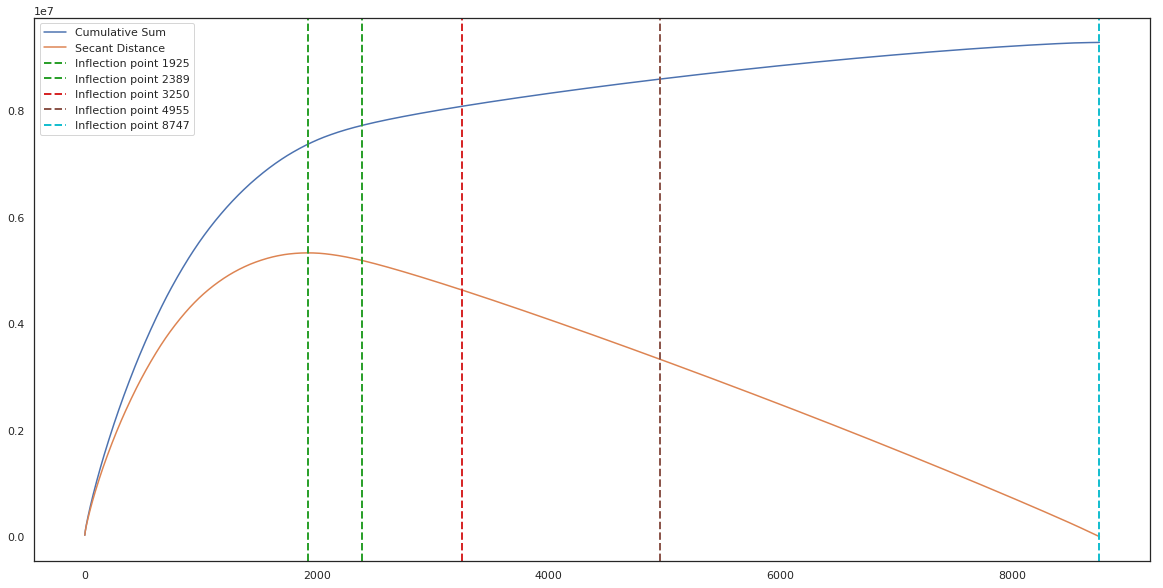

In [9]:
colon_lib.find_inflection(inflection_percentiles=[0,10,25, 50, 100])

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [10]:
colon_dr=dimension_reduction(colon_lib, 3250)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [11]:
%%time 
colon_dr.lib_size_normalize() 
colon_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
colon_dr.runPCA()
colon_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 43 neighbors
CPU times: user 48.3 s, sys: 8.52 s, total: 56.8 s
Wall time: 19.4 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [12]:
colon_gate = gate_visualize(colon_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

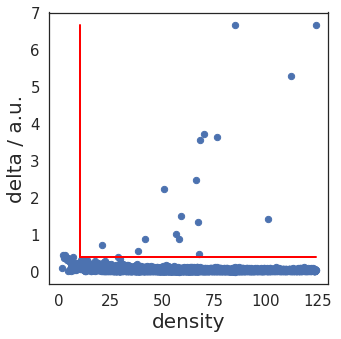

In [14]:
colon_gate.runDPC(colon_gate.UMAP,10,0.4) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

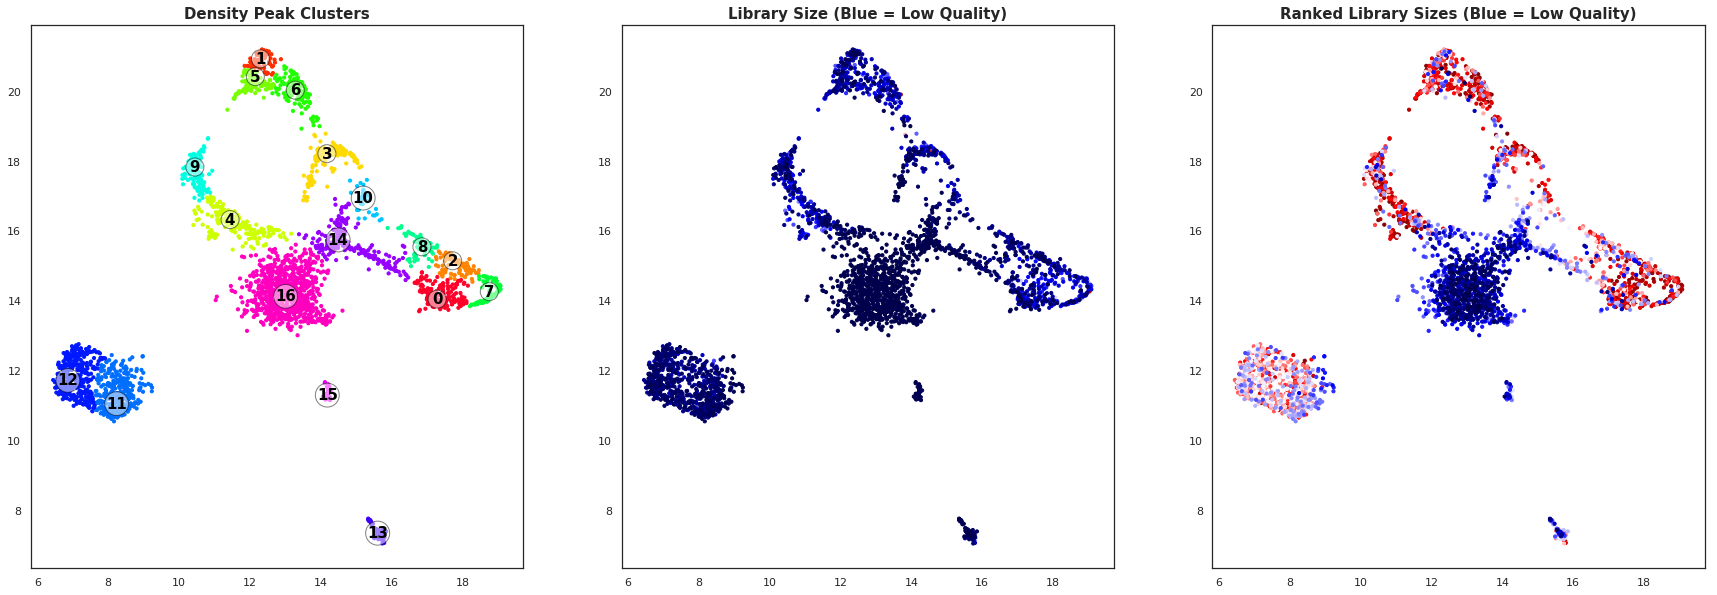

In [15]:
colon_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

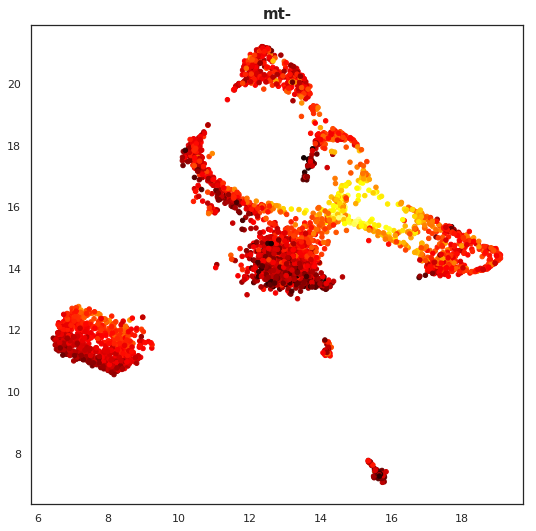

In [16]:
colon_gate.plotGenes(['mt-'])

Finally, we gate out clusters based on a combination of library metrics and the prior knowledge of target subpopulations. In this example, Clusters 10,11, and 12 are gated out due to their low library quality ranks. This function also returns the indices of cells after gating, which can be used to subset the original dataset for further analysis.

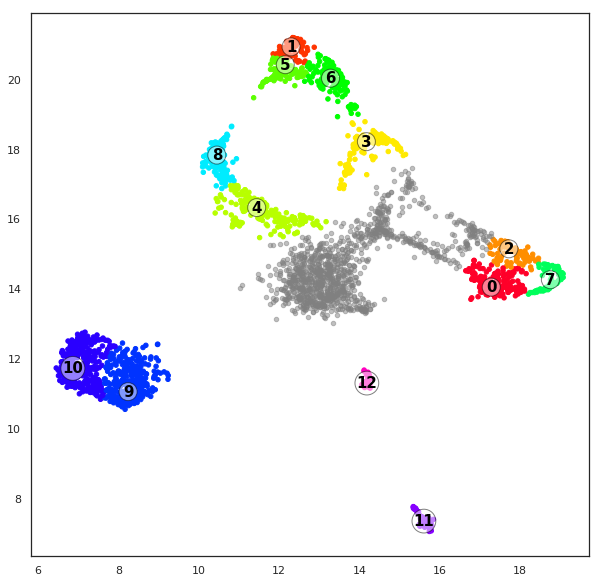

In [17]:
colon_remaining=colon_gate.manual_gating([16,14,8,10])

## Optional next iterations of quality control

We use the indices learned from the previous step to subset our original data so that we can further threshold library quality and gate cell subpopulations. 

In [18]:
second_run_data = colon_lib.lib_counts[colon_remaining]
second_run_cellID = colon_lib.lib_cellID[colon_remaining]

In [19]:
test_lib_second_run=library_data(second_run_data,second_run_cellID,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Inflection point at [ 870  717  571 2119] for [0, 15, 30, 100] percentiles of greatest secant distances


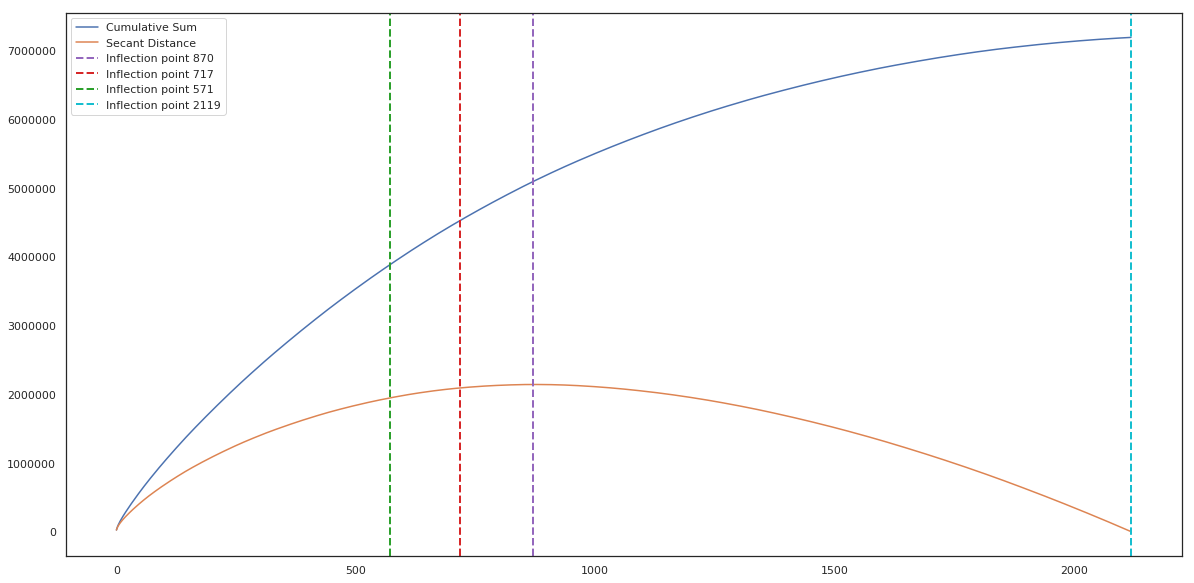

In [20]:
test_lib_second_run.find_inflection()

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [21]:
colon_dr=dimension_reduction(test_lib_second_run, 2119)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [22]:
%%time 
colon_dr.lib_size_normalize() 
colon_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
colon_dr.runPCA()
colon_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 10 neighbors
CPU times: user 28 s, sys: 7.56 s, total: 35.5 s
Wall time: 8.2 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [23]:
colon_gate = gate_visualize(colon_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

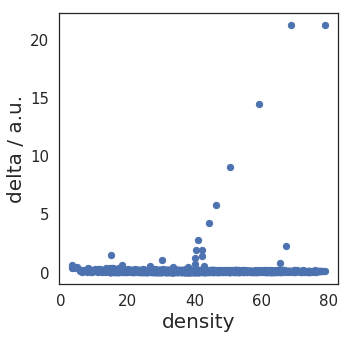

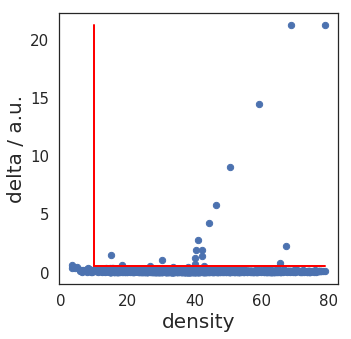

In [24]:
colon_gate.runDPC(colon_gate.UMAP,10,0.5) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

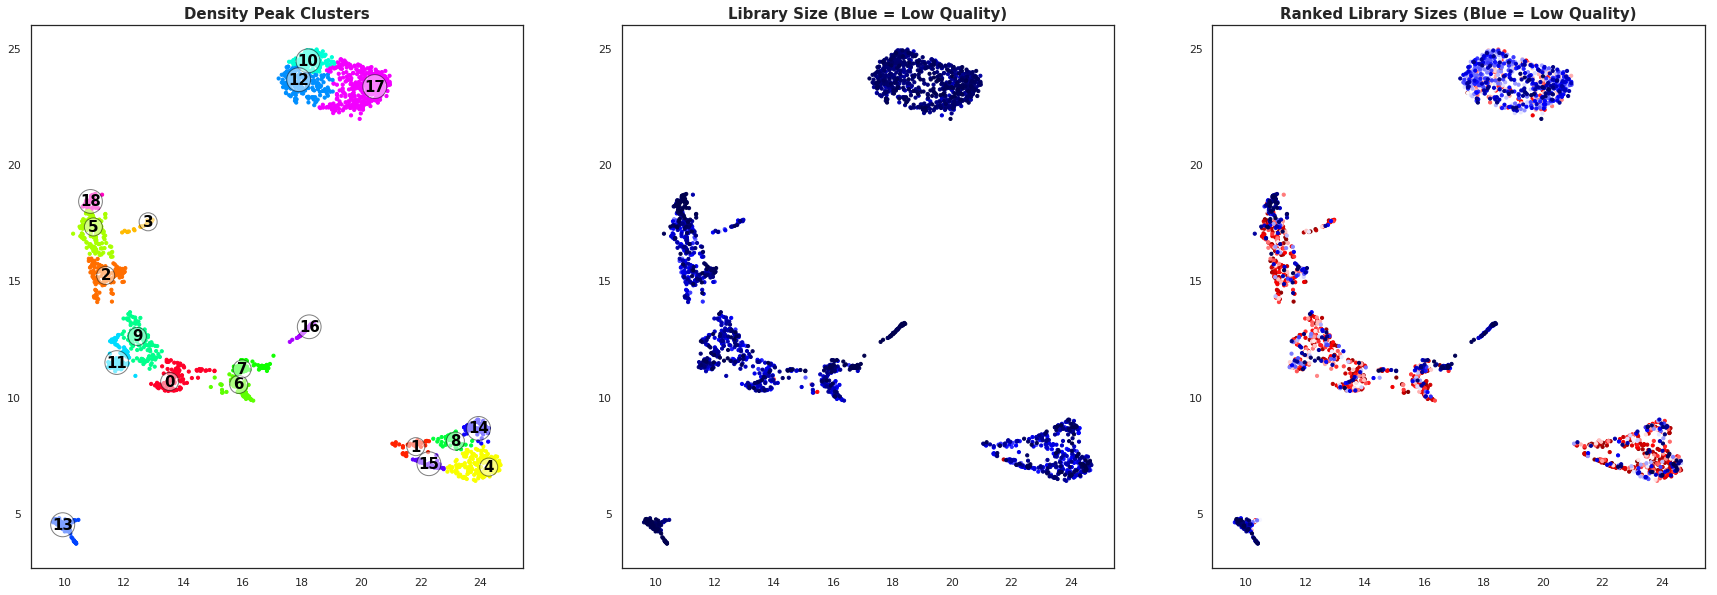

In [25]:
colon_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

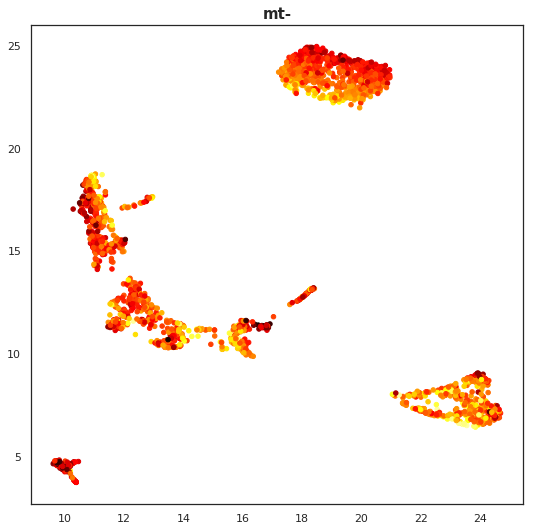

In [26]:
colon_gate.plotGenes(['mt-'])

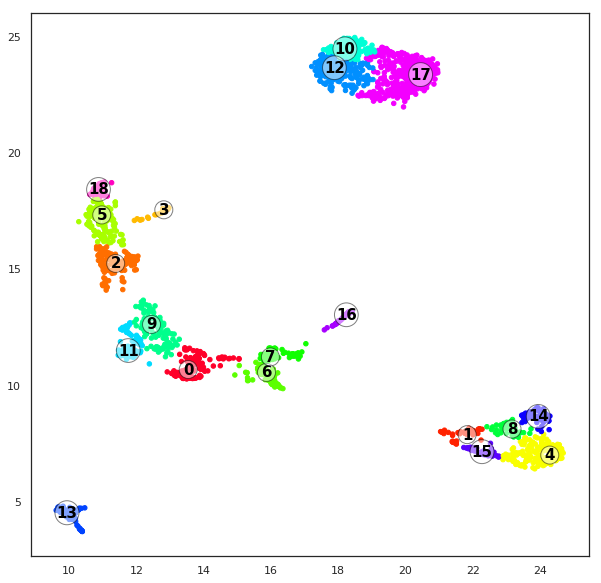

In [27]:
colon_remaining=colon_gate.manual_gating([])

## Data output 

We reconstruct a pandas dataframe for a quick check of the gated data and prepare it for writing to a .csv or any other format compatible with pandas dataframes.

In [28]:
colon_df = pd.DataFrame(test_lib_second_run.lib_counts[colon_remaining].toarray())
colon_df.index = test_lib_second_run.lib_cellID[colon_remaining]
colon_df.columns = test_lib_second_run.lib_geneID

In [29]:
colon_df.shape

(2119, 25505)

In [39]:
colon_df.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq_filtered_CH.tsv.gz', index=True, header=True, index_label='Cell', sep='\t', compression='gzip')

---
# Retina Dataset

In [41]:
%time retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

CPU times: user 11.7 s, sys: 247 ms, total: 12 s
Wall time: 12 s


In [42]:
retina.data.shape # check cells x genes

(6600, 20478)

Next, import the dataset for analysis. The QC preprocessing requires the data in three partitions.

1. Raw counts contained in a numpy.ndarray, as integers
2. Cell IDs in a 1-D numpy.ndarray, this can be barcodes or some other unique cell ID, with string datatype '<U16'
3. Gene IDs in a 1-D numpy.ndarray, these should be distinct gene names, with string datatype '<U16'

It also must be in a cell by gene, where each row represents a cell and each column represents a gene.

In [43]:
csr_counts=(retina.counts)
cellIDs=retina.cell_IDs
geneIDs=retina.gene_IDs

## Library_data object initialization for inflection point calculation and downstream operations

First, we pass the data organized above into a library_data object.

In [44]:
retina_lib=library_data(csr_counts,cellIDs,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Now we calculate the possible inflection points. This is done by finding the maximum distance between the cumulative sum curve and the secant line. These distances are then assigned a percentile score. By default, the inflection points are returned based off of four percentiles, 0, 15, 30 and 100. 0 represent the absolute maximum value for the aformentioned distance. 

A 15-30th percentile inflection point as to capture more libraries in preprocessing, using the 0th precentile runs the risk of cutting out useful, though relatively lower quality libraries. 

Inflection point at [1866 2197 1123 3863 6599] for [0, 10, 25, 50, 100] percentiles of greatest secant distances


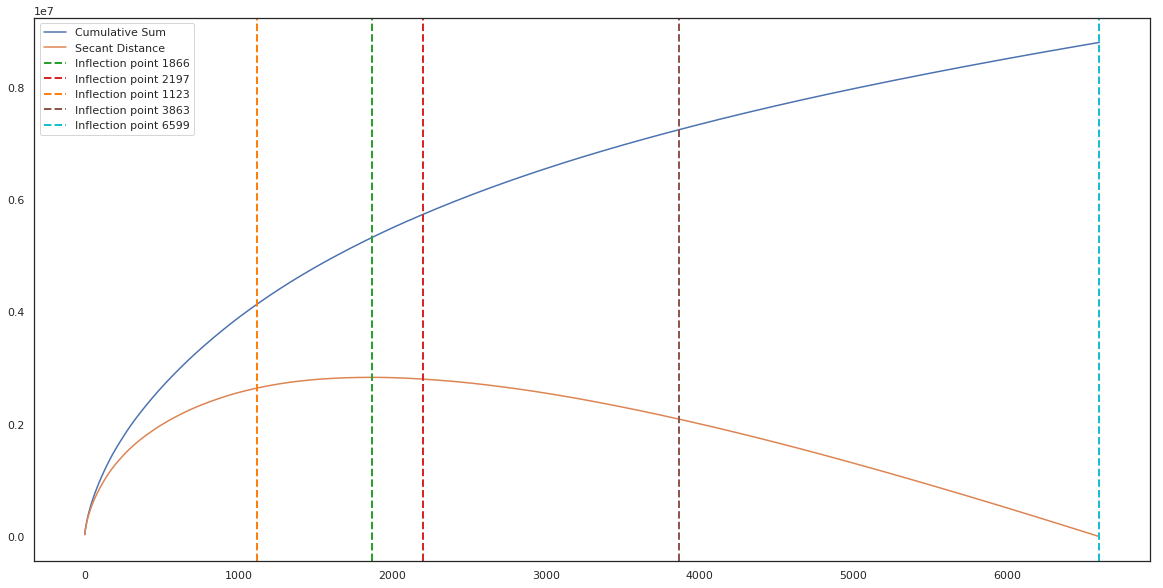

In [45]:
retina_lib.find_inflection(inflection_percentiles=[0,10,25, 50, 100])

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [46]:
retina_dr=dimension_reduction(retina_lib, 6599)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [47]:
%%time 
retina_dr.lib_size_normalize() 
retina_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
retina_dr.runPCA()
retina_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 33 neighbors
CPU times: user 1min 18s, sys: 8.41 s, total: 1min 27s
Wall time: 33.7 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [48]:
retina_gate = gate_visualize(retina_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

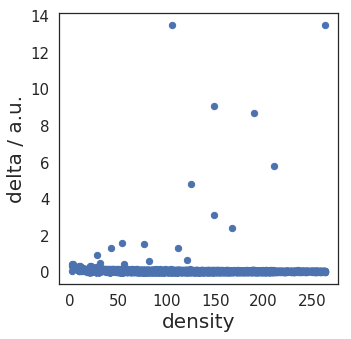

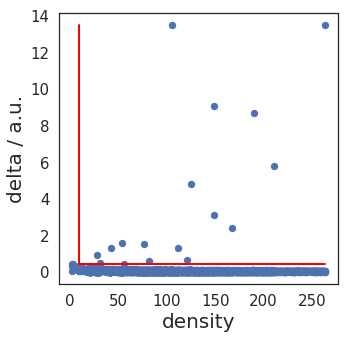

In [49]:
retina_gate.runDPC(retina_gate.UMAP,10,0.4) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

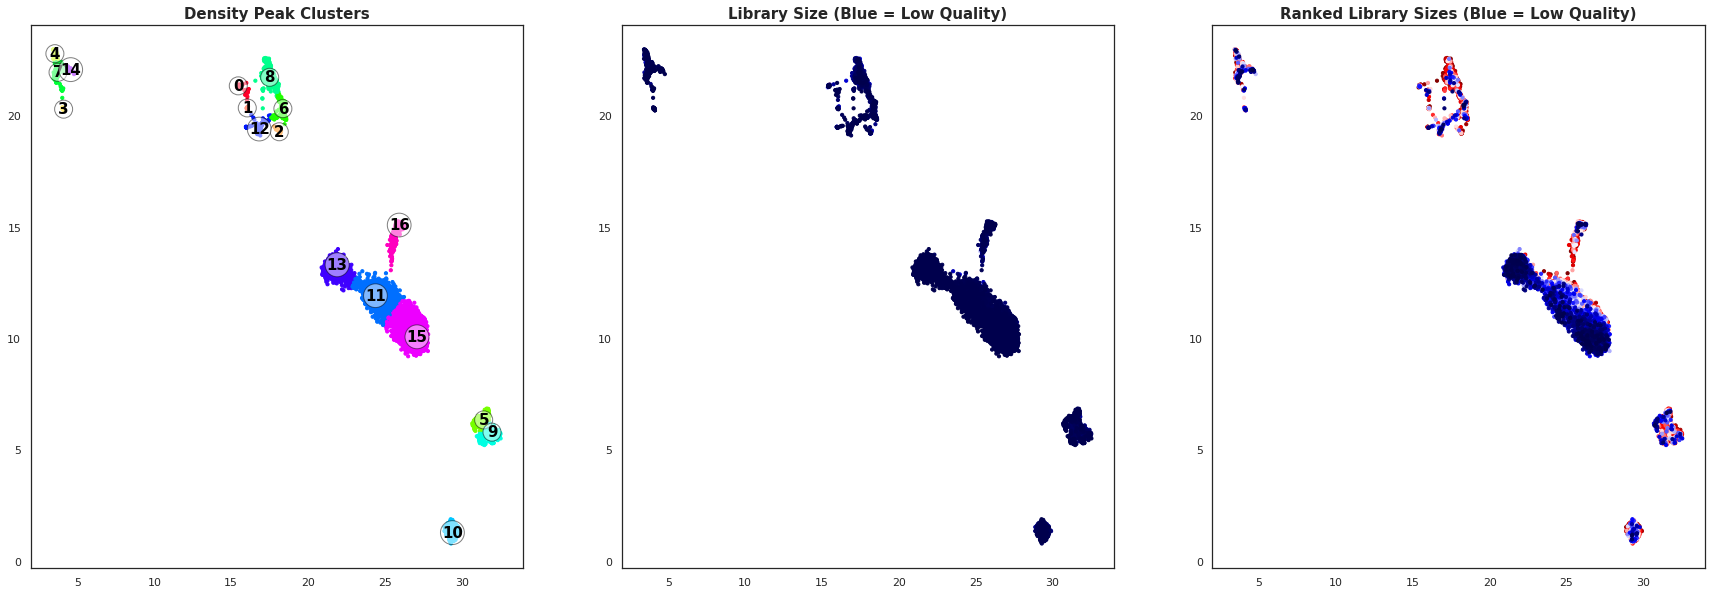

In [50]:
retina_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

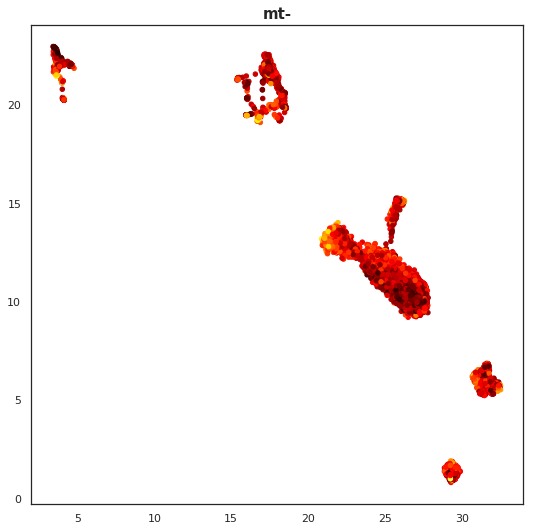

In [51]:
retina_gate.plotGenes(['mt-'])

Finally, we gate out clusters based on a combination of library metrics and the prior knowledge of target subpopulations. In this example, Clusters 10,11, and 12 are gated out due to their low library quality ranks. This function also returns the indices of cells after gating, which can be used to subset the original dataset for further analysis.

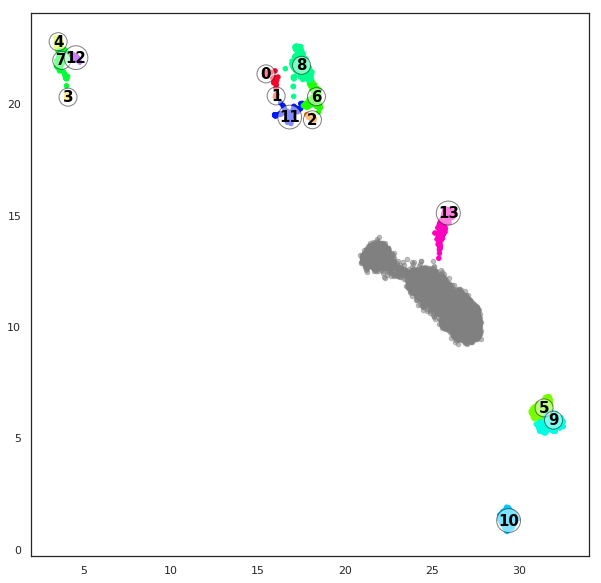

In [52]:
retina_remaining=retina_gate.manual_gating([13,11,15])

## Optional next iterations of quality control

We use the indices learned from the previous step to subset our original data so that we can further threshold library quality and gate cell subpopulations. 

In [53]:
second_run_data = retina_lib.lib_counts[retina_remaining]
second_run_cellID = retina_lib.lib_cellID[retina_remaining]

In [54]:
test_lib_second_run=library_data(second_run_data,second_run_cellID,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Inflection point at [ 886  693  513 2696] for [0, 15, 30, 100] percentiles of greatest secant distances


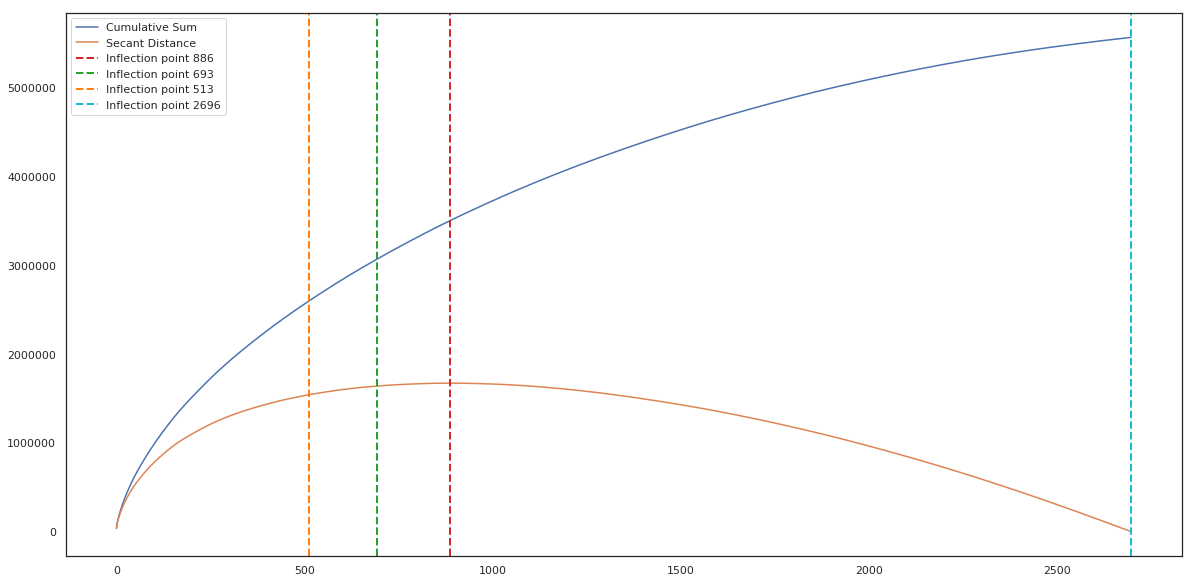

In [55]:
test_lib_second_run.find_inflection()

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [56]:
retina_dr=dimension_reduction(test_lib_second_run, 2696)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [57]:
%%time 
retina_dr.lib_size_normalize() 
retina_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
retina_dr.runPCA()
retina_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 13 neighbors
CPU times: user 30.5 s, sys: 8.57 s, total: 39.1 s
Wall time: 10.4 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [58]:
retina_gate = gate_visualize(retina_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

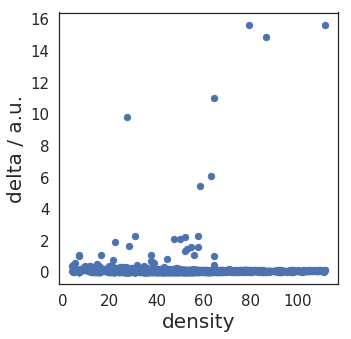

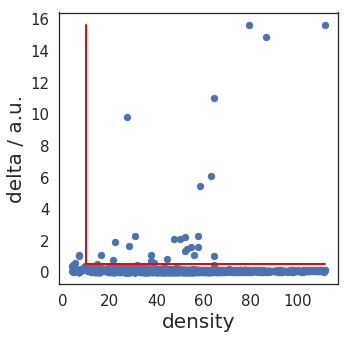

In [59]:
retina_gate.runDPC(retina_gate.UMAP,10,0.5) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

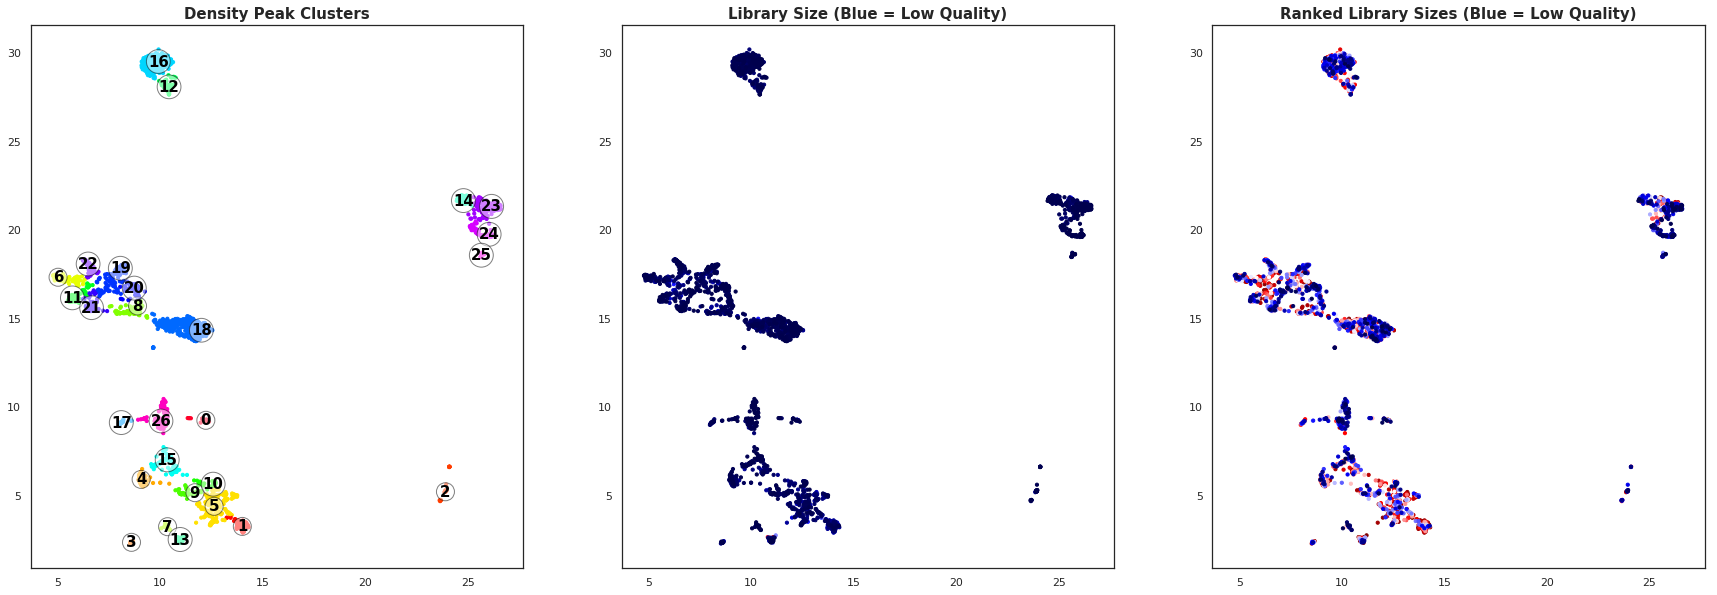

In [60]:
retina_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

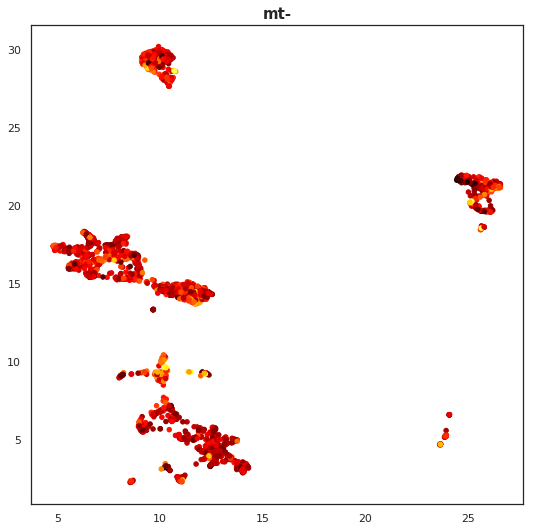

In [61]:
retina_gate.plotGenes(['mt-'])

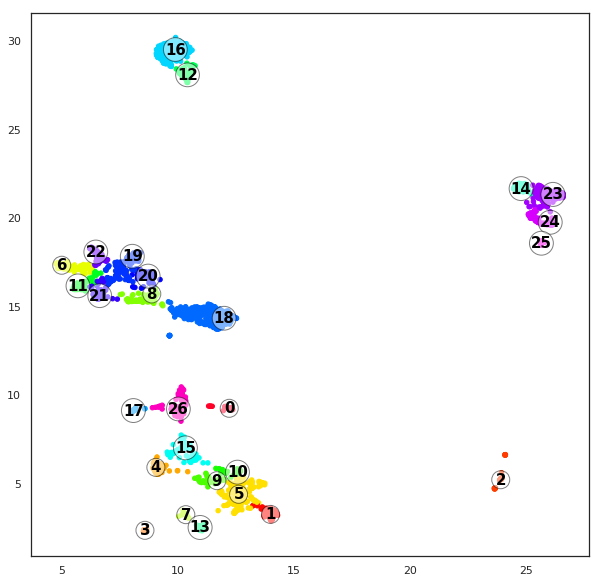

In [62]:
retina_remaining=retina_gate.manual_gating([])

## Data output 

We reconstruct a pandas dataframe for a quick check of the gated data and prepare it for writing to a .csv or any other format compatible with pandas dataframes.

In [64]:
retina_df = pd.DataFrame(test_lib_second_run.lib_counts[retina_remaining].toarray())
retina_df.index = test_lib_second_run.lib_cellID[retina_remaining]
retina_df.columns = test_lib_second_run.lib_geneID

In [65]:
retina_df.shape

(2696, 20478)

In [67]:
retina_df.to_csv('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz', index=True, header=True, index_label='Cell', sep='\t', compression='gzip')